# Анализ данных в задаче кредитного скоринга

In [27]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import *
from statsmodels.sandbox.stats.multicomp import multipletests 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

___

# Загрузка данных

In [28]:
credit_data = pd.read_csv('credit_card_data.csv')

___

# Описание данных

In [29]:
credit_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


`credit_card_default_analysis.csv` - данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- `LIMIT_BAL`: размер кредитного лимита (в том числе и на семью клиента)
- `SEX`: пол клиента (1 = мужской, 2 = женский )
- `EDUCATION`: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных )
- `MARRIAGE`: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных)
- `AGE`: возраст в годах
- `PAY_0` - `PAY_6` : История прошлых платежей по кредиту. `PAY_6` - платеж в апреле, ... `Pay_0` - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- `BILL_AMT1` - `BILL_AMT6`: задолженность, `BILL_AMT6` - на апрель, `BILL_AMT1` - на сентябрь
- `PAY_AMT1` - `PAY_AMT6`: сумма уплаченная в `PAY_AMT6` - апреле, ..., `PAY_AMT1` - сентябре
- `default` - индикатор невозврата денежных средств

In [30]:
print('Распределение между классами')
pd.DataFrame({'Количество': credit_data.default.value_counts().values},
             index=['Вернул кредит', 'Не вернул кредит'])

Распределение между классами


,Количество
Вернул кредит,23364
Не вернул кредит,6636


___

# Проверка гипотез

___

## Размер кредитного лимита (`LIMIT_BAL`)

Посмотрим на описательную статистику данного признака

In [31]:
print(credit_data.LIMIT_BAL.describe())
print('\nКоличество пропусков: ', credit_data.LIMIT_BAL.isnull().sum())

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

Количество пропусков:  0


Размах данного признака для тех, кто не вернул кредит

In [32]:
credit_data.LIMIT_BAL[credit_data.default == 1].max() - credit_data.LIMIT_BAL[credit_data.default == 1].min()

730000

Размах данного признака для тех, кто вернул кредит

In [33]:
credit_data.LIMIT_BAL[credit_data.default == 0].max() - credit_data.LIMIT_BAL[credit_data.default == 0].min()

990000

### Проверка гипотезы о равенстве медианных значений кредитного лимита

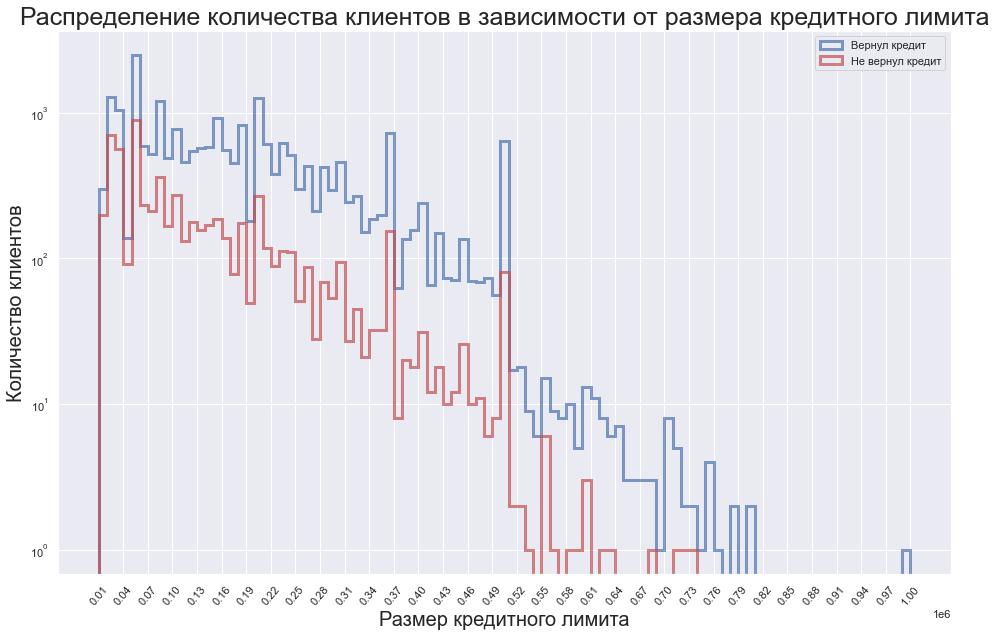

In [34]:
plt.figure(figsize=(16, 10))

sns.distplot(credit_data.LIMIT_BAL[credit_data.default == 0],
             hist_kws={"histtype": "step", "linewidth": 3,
                       "alpha": 0.7, 'edgecolor': 'b'}, 
             kde=False, bins=99)
sns.distplot(credit_data.LIMIT_BAL[credit_data.default == 1],
             hist_kws={"histtype": "step", "linewidth": 3,
                       "alpha": 0.7, 'edgecolor': 'r'},
             kde=False, bins=73)
plt.xticks(np.linspace(min(credit_data.LIMIT_BAL), max(credit_data.LIMIT_BAL), 34))
plt.xticks(rotation=50)
plt.legend(['Вернул кредит', 'Не вернул кредит'])
plt.yscale('log')
plt.xlabel('Размер кредитного лимита', fontsize=20)
plt.ylabel('Количество клиентов', fontsize=20)
plt.title('Распределение количества клиентов в зависимости от размера кредитного лимита', fontsize=25);

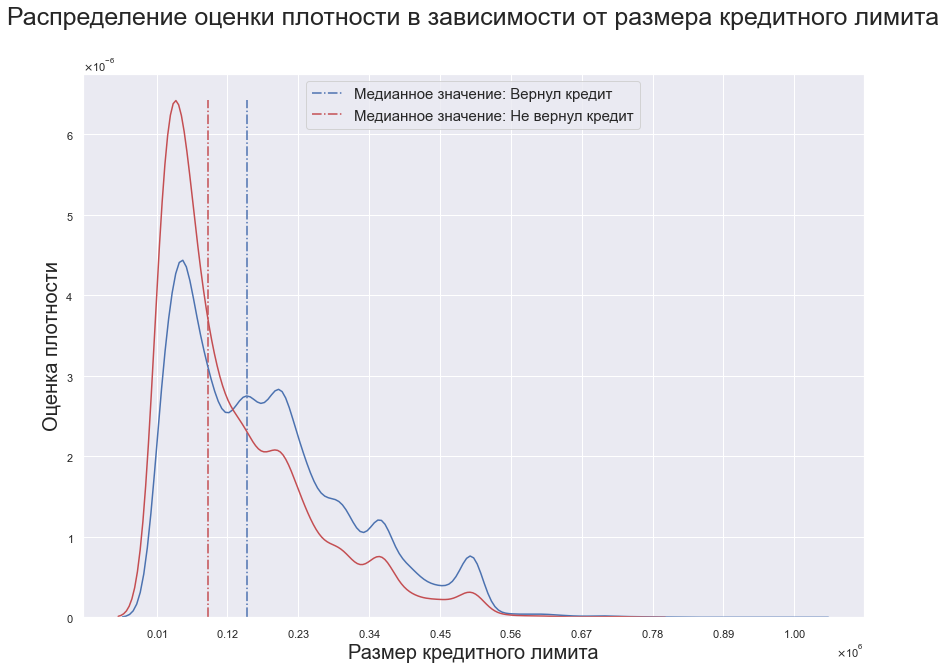

In [46]:
fig, ax = plt.subplots(figsize=(14, 10))
labels = ['Вернул кредит', 'Не вернул кредит']
colors = ['b', 'r']
vlines = []

for i in [0, 1]:
    _, y = sns.kdeplot(data=credit_data.LIMIT_BAL[credit_data.default == i],
                       legend=True, label=labels[i], color=colors[i]).get_lines()[0].get_data()
    x_median = credit_data.LIMIT_BAL[credit_data.default == i].median()
    y_median = y.max()*1.45
    vlines.append(plt.vlines(x_median, 0, y_median, linestyles='dashdot', colors=colors[i]))

from matplotlib.legend import Legend
leg = Legend(ax, vlines, ['Медианное значение: ' + labels[0], 'Медианное значение: ' + labels[1]], 
             loc=9, fontsize=15)
ax.add_artist(leg)

ax.ticklabel_format(useMathText=True)
plt.xlabel('Размер кредитного лимита', fontsize=20)
plt.ylabel('Оценка плотности', fontsize=20)
plt.title('Распределение оценки плотности в зависимости от размера кредитного лимита', 
          fontsize=25, y=1.08)
plt.xticks(np.linspace(min(credit_data.LIMIT_BAL), max(credit_data.LIMIT_BAL), 10));

По данным графикам можно заметить, что распределение людей, вернувших и не вернувших кредит, примерно одинаковое, причем людей, вернувших кредит на ту или иную сумму, больше, чем тех, кто его не вернул. Чаще всего размер кредитного лимита меньше 200000. Медианные значения находятся не так далеко друг от друга, но все-таки по графику они отличаются.

Построим 95% доверительный интервал для медианных значений. Для этого будет использовать бутстреп, так как про распределение медианы нам ничего не известно.

In [47]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [48]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [49]:
limit_bal_no_default = credit_data.LIMIT_BAL[credit_data.default == 0].values
limit_bal_default = credit_data.LIMIT_BAL[credit_data.default == 1].values

Проверим следующую гипотезу:

$H_0\colon med(X_1) = med(X_2)$ - медианные значения двух выборок равны

$H_1\colon med(X_1) \neq med(X_2)$ - медианные значения двух выборок не равны

In [50]:
np.random.seed(0)

lbnd_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_no_default, 10000)))
lbd_median_scores = list(map(np.median, get_bootstrap_samples(limit_bal_default, 10000)))

print("99.99% доверительный интервал медианного значения кредитного лимита (вернули кредит):",
      stat_intervals(lbnd_median_scores, 0.0001))
print("99.99% доверительный интервал медианного значения кредитного лимита (не вернули кредит):",
      stat_intervals(lbd_median_scores, 0.0001))

99.99% доверительный интервал медианного значения кредитного лимита (вернули кредит): [150000. 160000.]
99.99% доверительный интервал медианного значения кредитного лимита (не вернули кредит): [ 80000. 100000.]


Так как 99.99% доверительный интервал медианного значения кредитного лимита тех, кто вернул кредит, полностью лежит правее, чем доверительный интервал тех, кто кредит не вернул, то, скорее всего, данные медианные значения действительно не равны друг другу.



Произведем интервальную оценку разности медиан

In [51]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(lbd_median_scores, lbnd_median_scores)))

In [52]:
print("99.9% доверительный интервал для разности двух медиан",  stat_intervals(delta_median_scores, 0.001))

99.9% доверительный интервал для разности двух медиан [50000. 70000.]


Данный доверительный интервал не содержит 0, значит, что на уровне 0.001 нулевую гипотезу о равенстве медиан мы отвергаем.

### Проверка гипотезы о равенстве распределений  значений кредитного лимита

Проверим следующую гипотезу:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ - функции распределения одинаковы

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - функции распределения не одинаковы

В качестве функции распределения передадим выборки `limit_bal_no_default` и `limit_bal_default` соответственно и проверим гипотезы с помощью Рангового критерия Уилкоксона-Манна-Уитни. Так как в каждой выборке более 10 объектов, то аппроксимация нулевого распределения нормальным имеет место.

In [53]:
print('p-value =', stats.mannwhitneyu(limit_bal_no_default, limit_bal_default).pvalue)

p-value = 6.127742909111652e-190


Достигаемый уровень значимости получается ничтожно мал, следовательно, мы можем опровергнуть $H_0$ как минимум на уровне 0.05.

__Вывод__: В среднем, значение кредитного лимита тех, кто вернул кредит, значимо больше, чем тех, кто кредит не вернул. Действительно, тот, кто возвращает кредит, имеет больший уровень доверия банка и тем самым имеет больший размер кредитного лимита.

___

## Пол (`SEX`)

Посмотрим на распределение полов по выборке

In [54]:
credit_data.SEX.value_counts().rename(index={1: 'Количество мужчин', 2: 'Количество женщин'})

Количество женщин    18112
Количество мужчин    11888
Name: SEX, dtype: int64

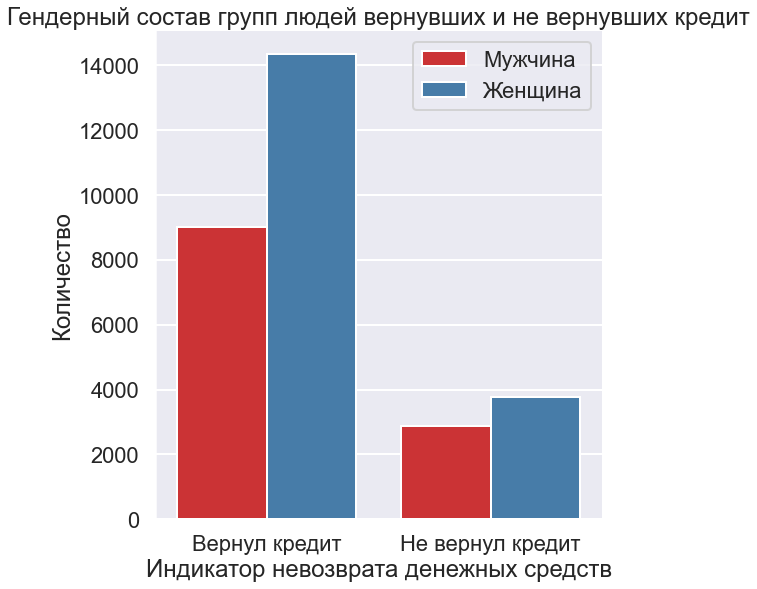

In [55]:
sns.set_context("poster")
sns.catplot(x="default", hue="SEX", data=credit_data, legend=False,
            kind="count", palette="Set1", height=8)\
            .set_xticklabels(labels)\
            .set_axis_labels("Индикатор невозврата денежных средств", "Количество")

plt.legend(['Мужчина', 'Женщина'])
plt.title('Гендерный состав групп людей вернувших и не вернувших кредит');

По данному графику мы видим, что чаще всего берут кредит женщины. Также в двух случаях (возвравта и не возврата денежных средств) количество мужчин немного больше половины количества женщин.

### Проверка гипотезы о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

Построим доверительный интервал для разности долей двух независимых выборок.

   |Пол\Индикатор невозврата денежных средств|Вернул(а) кредит | Не вернул(а) кредит  
   -|------------- | -------------|
   Женщина| a | b 
   Мужчина| c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

Проверим следующую гипотезу:

$H_0\colon \hat{p}_1 = \hat{p}_2$ - гендерный состав группы людей вернувших и не вернувших кредит не отличается

$H_1\colon \hat{p}_1 \neq \hat{p}_2$ - гендерный состав группы людей вернувших и не вернувших кредит отличается

In [63]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = sample1[0] / np.sum(sample1)
    p2 = sample2[0] / np.sum(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ np.sum(sample1) +\
                                            p2 * (1 - p2)/ np.sum(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ np.sum(sample1) +\
                                             p2 * (1 - p2)/ np.sum(sample2))
    
    return (left_boundary, right_boundary)

In [64]:
sex_prop = credit_data.pivot_table('ID', 'SEX', 'default', 'count')\
                      .rename(index={1: 'Мужчина', 2: 'Женщина'},
                              columns={0: 'Вернул(а) кредит', 
                                       1: 'Не вернул(а) кредит'}).iloc[::-1]
sex_prop

default,Вернул(а) кредит,Не вернул(а) кредит
SEX,,
Женщина,14349,3763
Мужчина,9015,2873


In [58]:
proportions_confint_diff_ind(sex_prop['Вернул(а) кредит'], sex_prop['Не вернул(а) кредит'], 0.001)

(0.024499655590836705, 0.06968335513368869)

Данный доверительный интервал не содержит 0, значит, что на уровне 0.001 нулевую гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит не отличается, отвергаем.

In [59]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = np.sum(sample1)
    n2 = np.sum(sample2)
    
    p1 = sample1[0] / n1
    p2 = sample2[0] / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [60]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [62]:
print("p-value:", 
      proportions_diff_z_test(proportions_diff_z_stat_ind(
          sex_prop['Вернул(а) кредит'],
          sex_prop['Не вернул(а) кредит'])))

p-value: 4.472866521609831e-12


Достигаемый уровень значимости получается очень маленьким, следовательно, мы можем опровергнуть $H_0$ как минимум на уровне 0.05.

__Вывод__: Доля женщин в группе, вернувшей кредит, больше, чем доля женщин в группе, не вернувшей кредит. Практически это может значить, что женщины более склонны к возврату кредита, чем мужчины.

___

## Образование (`EDUCATION`)

Посмотрим на распределение людей по категориям образования

In [65]:
education_labels = ['Доктор', 'Магистр', 'Бакалавр', 'Выпускник школы', 
                    'Начальное образование', 'Прочее', 'Нет данных']

credit_data.EDUCATION.value_counts().rename(index={i: education for i, education in enumerate(education_labels)})

Бакалавр                 14030
Магистр                  10585
Выпускник школы           4917
Прочее                     280
Начальное образование      123
Нет данных                  51
Доктор                      14
Name: EDUCATION, dtype: int64

На основе имеющихся данных построим таблицу сопряженности "образование" на "возврат долга" наблюдаемых значений 

In [67]:
education_prop = credit_data.pivot_table('ID', 'EDUCATION', 'default', 'count', 0)\
                      .rename(index={i: education for i, education in enumerate(education_labels)},
                              columns={0: 'Количество вернувших кредит', 
                                       1: 'Количество не вернувших кредит'})

education_prop.index.name = 'Образование'
education_prop.columns.name = 'Индикатор невозврата денежных средств'
education_prop

Индикатор невозврата денежных средств,Количество вернувших кредит,Количество не вернувших кредит
Образование,,
Доктор,14,0
Магистр,8549,2036
Бакалавр,10700,3330
Выпускник школы,3680,1237
Начальное образование,116,7
Прочее,262,18
Нет данных,43,8


Аналогично построим таблицу сопряженности ожидаемы значений на основе критерия Хи-квадрат (`scipy.stats.chi2_contingency`)

In [69]:
expected_education = chi2_contingency(education_prop)[3]
expected_education = pd.DataFrame({'Ожидаемое количество вернувших кредит': 
                                   expected_education[:, 0],
                                   'Ожидаемое количество не вернувших кредит':
                                   expected_education[:, 1]}, 
                                  index=education_labels).astype(int)
expected_education.index.name = 'Образование'
expected_education.columns.name = 'Индикатор невозврата денежных средств'

expected_education

Индикатор невозврата денежных средств,Ожидаемое количество вернувших кредит,Ожидаемое количество не вернувших кредит
Образование,,
Доктор,10,3
Магистр,8243,2341
Бакалавр,10926,3103
Выпускник школы,3829,1087
Начальное образование,95,27
Прочее,218,61
Нет данных,39,11


Представим данные таблицы на одном графике.

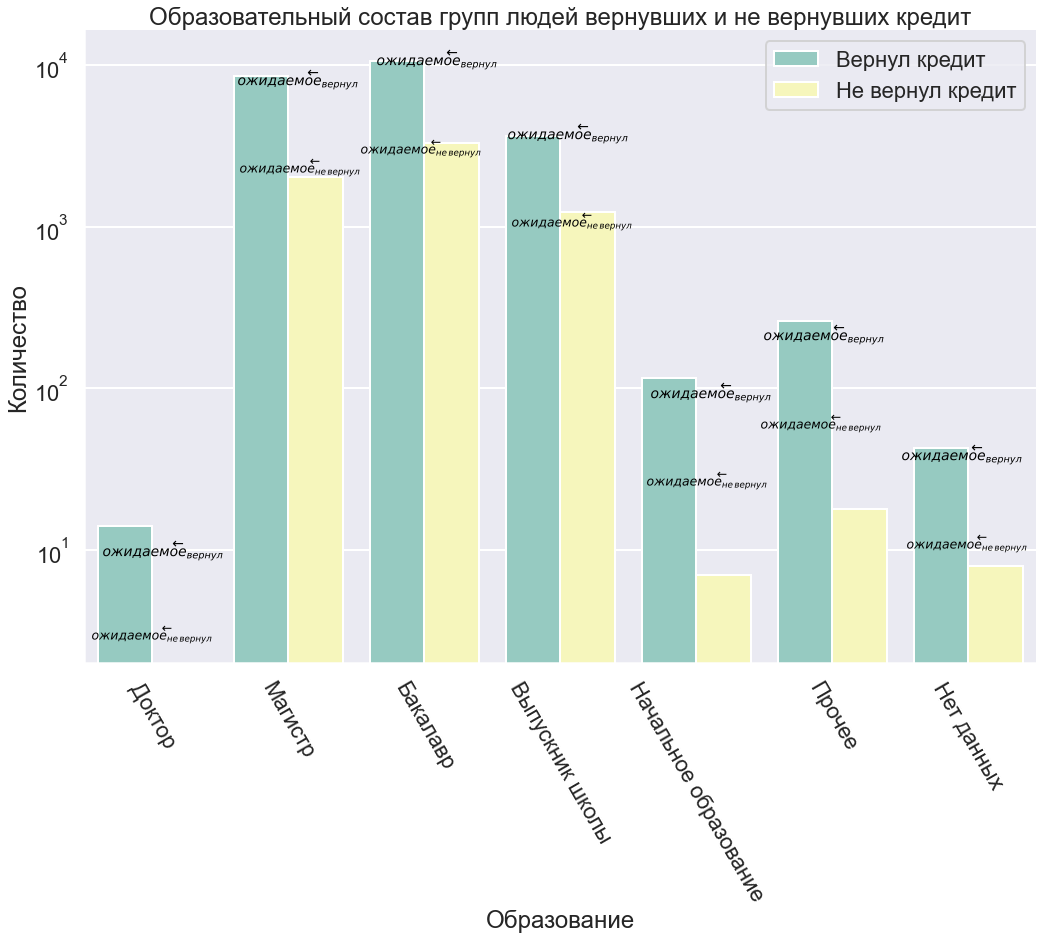

In [70]:
sns.set_context("poster")

sns.catplot(x="EDUCATION", hue="default", data=credit_data, legend=False,
            kind="count", palette="Set3", height=10,  aspect=1.5)\
            .set_xticklabels(education_labels)\
            .set_axis_labels("Образование")


plt.xticks(rotation=-60)

plt.legend(labels)
plt.title('Образовательный состав групп людей вернувших и не вернувших кредит')

sns.stripplot(x=expected_education.index, y=expected_education.iloc[:, 0], 
              color="black", marker="$\overleftarrow{ожидаемое_{вернул}}$", 
              size=120)
sns.stripplot(x=expected_education.index, y=expected_education.iloc[:, 1], 
              color="black", marker="$\overleftarrow{ожидаемое_{не\,вернул}}$", 
              size=120)
plt.yscale('log')
plt.ylabel('Количество');

По графику видно, что реальные значения количества людей вернувших и не вернувших кредит отличаются в зависимости от образования. Cоставим таблицу сопряженности "образование" на "возврат долга", где значение ячейки есть процент количества людей вернувших или не вернувших долг в зависимости от образования.

In [71]:
prop_no_default = ((education_prop.iloc[:, 0] / education_prop.sum(axis=1))\
                   * 100).astype(int)
prop_default = 100 - prop_no_default
education_procents = pd.DataFrame({'Процент вернувших кредит': prop_no_default,
                                   'Процент не вернувших кредит': prop_default}, 
                                  index=education_labels).astype(int)

education_procents.sort_values(by='Процент вернувших кредит', ascending=False)

,Процент вернувших кредит,Процент не вернувших кредит
Доктор,100,0
Начальное образование,94,6
Прочее,93,7
Нет данных,84,16
Магистр,80,20
Бакалавр,76,24
Выпускник школы,74,26


По данной таблице мы видим, что лучше всего отдают долг люди, которые имеют образование Доктора или Начальное образование. Хуже всего отдают долг люди, которые имеют образование Бакалавра и Выпускника школы. 

Найдем все комбинации пар людей с разными образованиями

In [72]:
from itertools import combinations

pairs = list(combinations(education_procents.index, 2))
pairs

[('Доктор', 'Магистр'),
 ('Доктор', 'Бакалавр'),
 ('Доктор', 'Выпускник школы'),
 ('Доктор', 'Начальное образование'),
 ('Доктор', 'Прочее'),
 ('Доктор', 'Нет данных'),
 ('Магистр', 'Бакалавр'),
 ('Магистр', 'Выпускник школы'),
 ('Магистр', 'Начальное образование'),
 ('Магистр', 'Прочее'),
 ('Магистр', 'Нет данных'),
 ('Бакалавр', 'Выпускник школы'),
 ('Бакалавр', 'Начальное образование'),
 ('Бакалавр', 'Прочее'),
 ('Бакалавр', 'Нет данных'),
 ('Выпускник школы', 'Начальное образование'),
 ('Выпускник школы', 'Прочее'),
 ('Выпускник школы', 'Нет данных'),
 ('Начальное образование', 'Прочее'),
 ('Начальное образование', 'Нет данных'),
 ('Прочее', 'Нет данных')]

### Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг

Для каждой такой пары построим таблицу сопряженности 2x2 вида:


   |Индикатор невозврата денежных средств\Образование|EDUCATION_1|EDUCATION_2
   -|------------- | -------------|
   Вернул(а) кредит| a | b 
   Не вернул(а) кредит| c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$

Также посчитаем значение Z-статистики для каждой такой пары:

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

Проверим для каждой таблицы следующую гипотезу:

$H_0\colon \hat{p}_1 = \hat{p}_2$ - соотношение вернувших кредит ко всем отличается в зависимости от образования

$H_1\colon \hat{p}_1 \neq \hat{p}_2$ - соотношение вернувших кредит ко всем не отличается в зависимости от образования

In [73]:
prop_test_df = []

for pair in pairs:
    table = np.array([education_prop.loc[pair[0]].values,
                      education_prop.loc[pair[1]].values]).T
    prop_test_df.append([pair[0], pair[1], 
                        proportions_diff_z_test(
                            proportions_diff_z_stat_ind(table[:, 0],table[:, 1])
                        )])

prop_test_df = pd.DataFrame(prop_test_df, columns=['Education_1', 
                                                   'Education_2', 'p_value'])
prop_test_df

,Education_1,Education_2,p_value
0,Доктор,Магистр,6.789703e-02
1,Доктор,Бакалавр,3.688621e-02
2,Доктор,Выпускник школы,3.013646e-02
3,Доктор,Начальное образование,3.594970e-01
4,Доктор,Прочее,3.275157e-01
5,Доктор,Нет данных,1.135359e-01
6,Магистр,Бакалавр,0.000000e+00
7,Магистр,Выпускник школы,0.000000e+00
8,Магистр,Начальное образование,1.442485e-04
9,Магистр,Прочее,6.593846e-08


Сделаем поправку на множественную проверку методом Холма.

In [74]:
reject, p_corrected, a1, a2 = multipletests(prop_test_df.p_value, 
                                            alpha = 0.05, 
                                            method = 'holm') 

prop_test_df['p_corrected'] = p_corrected
prop_test_df['reject'] = reject
prop_test_df

,Education_1,Education_2,p_value,p_corrected,reject
0,Доктор,Магистр,6.789703e-02,5.431762e-01,False
1,Доктор,Бакалавр,3.688621e-02,3.688621e-01,False
2,Доктор,Выпускник школы,3.013646e-02,3.616375e-01,False
3,Доктор,Начальное образование,3.594970e-01,1.000000e+00,False
4,Доктор,Прочее,3.275157e-01,1.000000e+00,False
5,Доктор,Нет данных,1.135359e-01,7.947515e-01,False
6,Магистр,Бакалавр,0.000000e+00,0.000000e+00,True
7,Магистр,Выпускник школы,0.000000e+00,0.000000e+00,True
8,Магистр,Начальное образование,1.442485e-04,2.019479e-03,True
9,Магистр,Прочее,6.593846e-08,1.120954e-06,True


__Вывод__: Образование действительно влияет на критерий возврата кредита.

___

## Семейное положение (`MARRIAGE`)

Посмотрим на распределение данного признака

In [75]:
marriage_labels = {0: 'отказываюсь отвечать', 1: 'замужем/женат', 
                   2: 'холост', 3: 'нет данных'}

credit_data.MARRIAGE.value_counts().rename(index=marriage_labels)

холост                  15964
замужем/женат           13659
нет данных                323
отказываюсь отвечать       54
Name: MARRIAGE, dtype: int64

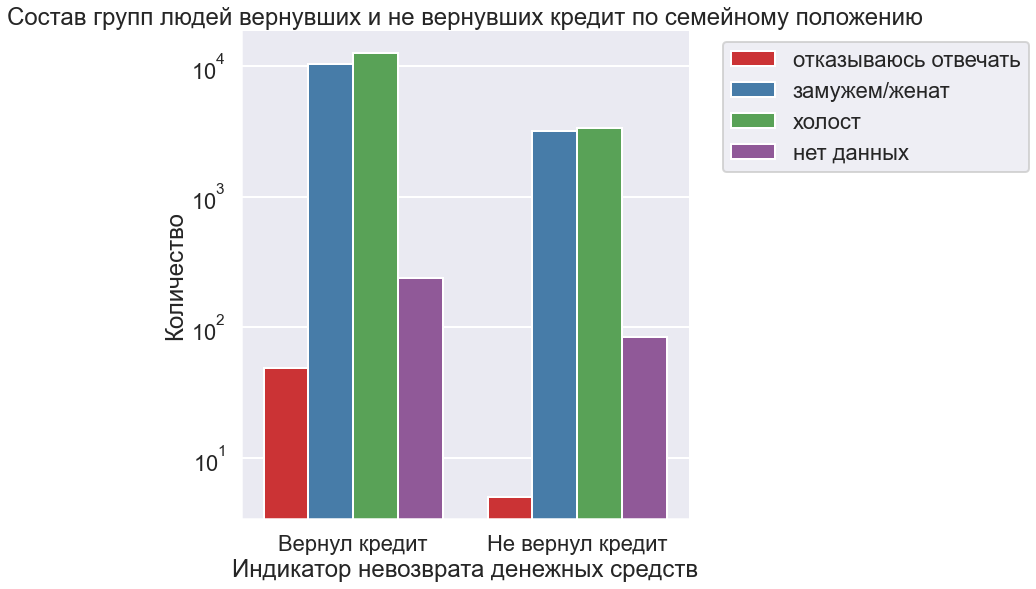

In [76]:
sns.catplot(x="default", hue="MARRIAGE", data=credit_data, legend=False,
            kind="count", palette="Set1", height=8)\
            .set_xticklabels(labels)\
            .set_axis_labels("Индикатор невозврата денежных средств", 
                             "Количество")

plt.legend(marriage_labels.values(), bbox_to_anchor=(1.05, 1.0))
plt.yscale('log')
plt.title('Cостав групп людей вернувших и не вернувших кредит по семейному положению');

По данному графику видно, что семейное положение почти никак не влияет на индикатор невозврата денежных средств. Построим таблицу сопряженности "семейное положение" на "Индикатор невозврата денежных средств".

In [77]:
marriage_prop = credit_data.pivot_table('ID', 'MARRIAGE', 
                                        'default', 'count', 0)\
                      .rename(index=marriage_labels,
                              columns={0: 'Количество вернувших кредит', 
                                       1: 'Количество не вернувших кредит'})

marriage_prop.index.name = 'Семейное положение'
marriage_prop.columns.name = 'Индикатор невозврата денежных средств'
marriage_prop

Индикатор невозврата денежных средств,Количество вернувших кредит,Количество не вернувших кредит
Семейное положение,,
отказываюсь отвечать,49,5
замужем/женат,10453,3206
холост,12623,3341
нет данных,239,84


### Проверим, как связан семейный статус с индикатором дефолта

Воспользуемся коэффициентом  Хи-Квадрат для проверки следующих гипотез:

$H_0\colon \phi_c(X_1^n, X_2^n) = 0$ - коэффициент V-Крамера равен нулю

$H_1\colon \phi_c(X_1^n, X_2^n) \neq 0$ - коэффициент V-Крамера не равен нулю

Выборки достаточно большие ($ n \geq 40$) и ожидаемое количество элементов в каждой ячейке таблицы меньше 5, не более, чем в 20% ячеек.

In [78]:
(chi2_contingency(marriage_prop)[3] > 5).sum()

8

In [79]:
print('p-value:', chi2_contingency(marriage_prop)[1])

p-value: 8.825862457577375e-08


На уровне значимости 0.05 можно опровергнуть гипотезу о том, что коэффициент V-Крамера равен нулю. Вычислим данный коэффициент.

In [80]:
def kramer_coeff(table):
    chi2 = chi2_contingency(table)[0]
    n = np.sum(table)
    return np.sqrt(chi2 / (n*(np.min(table.shape) - 1)))

In [81]:
print('Значение коэффициента V Крамера: {:.4f}'\
      .format(kramer_coeff(marriage_prop.values)))

Значение коэффициента V Крамера: 0.0345


Коэффициент действительно не равен нулю, но он очень мал.

__Вывод__: Семейный статус почти никак не связан с показателем дефолта.

___

## Возраст (`AGE`)

Посмотрим на описательную статистику данного признака

In [82]:
print(credit_data.AGE.describe()[[0,1,2,3,7]].astype(int)\
      .rename({'count': 'Всего людей',
               'mean': 'Средний возраст', 
               'std': 'Стандартное отклонение', 
               'min': 'Минимальный возраст',
               'max': 'Максимальный возраст'}))

Всего людей               30000
Средний возраст              35
Стандартное отклонение        9
Минимальный возраст          21
Максимальный возраст         79
Name: AGE, dtype: int64


### Проверка гипотезы о равенстве медианных значений возрастов людей

Построим графики распределения данного признака относительно индикатора дефолта и оценим их плотности.

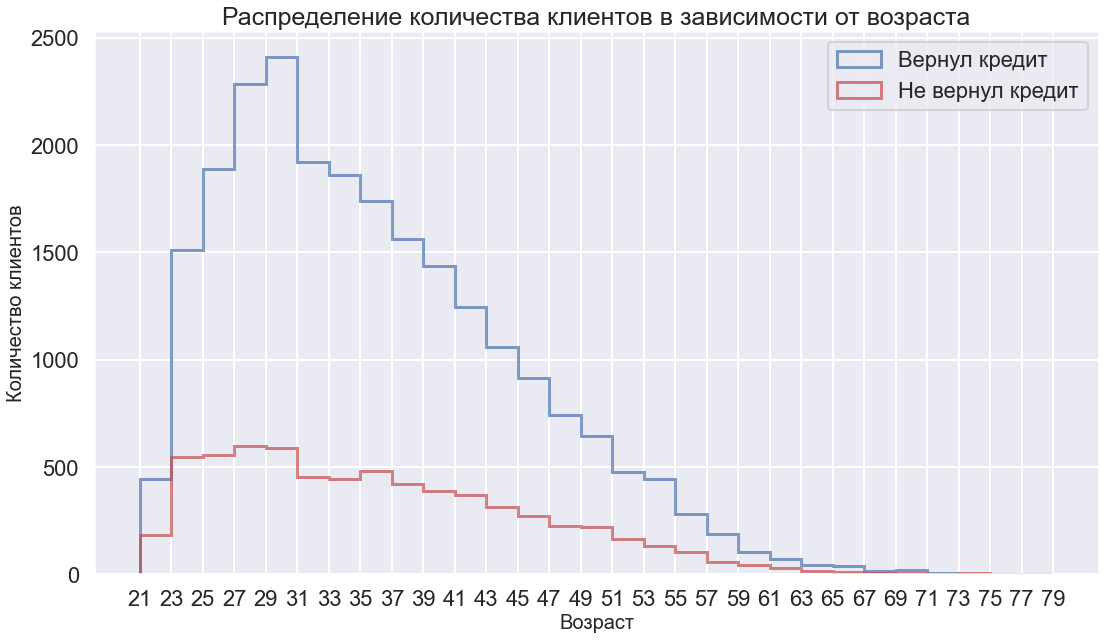

In [83]:
plt.figure(figsize=(18, 10))

sns.distplot(credit_data.AGE[credit_data.default == 0],
             hist_kws={"histtype": "step", "linewidth": 3,
                       "alpha": 0.7, 'edgecolor': 'b'}, 
             kde=False, bins=29)
sns.distplot(credit_data.AGE[credit_data.default == 1],
             hist_kws={"histtype": "step", "linewidth": 3,
                       "alpha": 0.7, 'edgecolor': 'r'},
             kde=False, bins=27)

plt.xticks(np.linspace(min(credit_data.AGE), max(credit_data.AGE), 30))
plt.legend(['Вернул кредит', 'Не вернул кредит'])
plt.xlabel('Возраст', fontsize=20)
plt.ylabel('Количество клиентов', fontsize=20)
plt.title('Распределение количества клиентов в зависимости от возраста',
          fontsize=25);

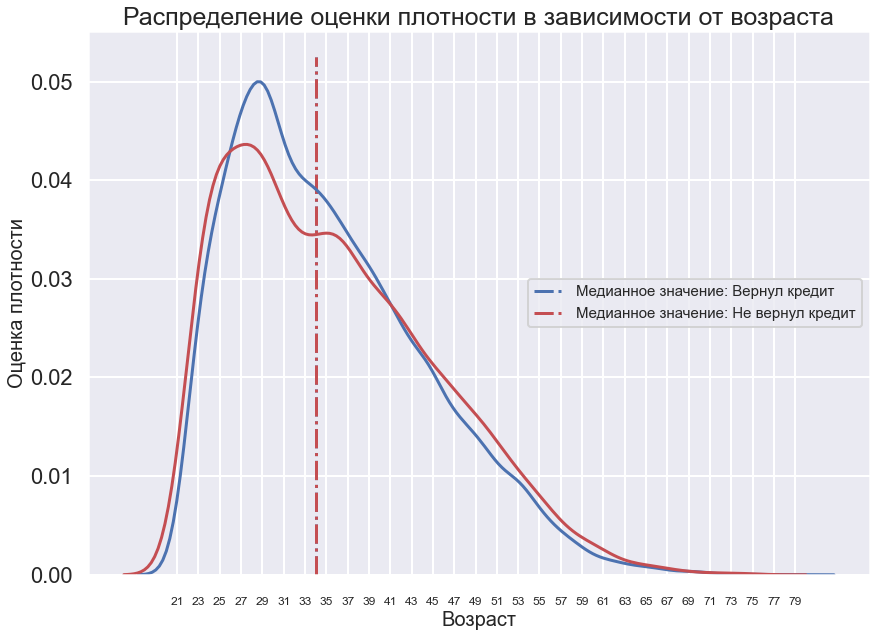

In [84]:
fig, ax = plt.subplots(figsize=(14, 10))
vlines = []

for i in [0, 1]:
    _, y = sns.kdeplot(data=credit_data.AGE[credit_data.default == i], 
                       legend=True, label=labels[i], 
                       color=colors[i]).get_lines()[0].get_data()
    x_median = credit_data.AGE[credit_data.default == i].median()
    y_median = y.max()*1.05
    vlines.append(plt.vlines(x_median, 0, y_median, linestyles='dashdot', 
                             colors=colors[i]))

from matplotlib.legend import Legend
leg = Legend(ax, vlines, ['Медианное значение: ' + labels[0], 
                          'Медианное значение: ' + labels[1]], 
             loc=7, fontsize=15)
ax.add_artist(leg)

plt.xlabel('Возраст', fontsize=20)
plt.ylabel('Оценка плотности', fontsize=20)
plt.title('Распределение оценки плотности в зависимости от возраста', 
          fontsize=25)
plt.xticks(np.linspace(min(credit_data.AGE), max(credit_data.AGE), 30))
ax.tick_params(axis='x', pad=10, labelsize=12);

По первому графику видно, что количество людей, вернувших кредит, распределено вокруг 29 лет. Также это актуально и для тех, кто кредит не вернул, но это менее выраженно из-за меньшего их количества. По второму графику мы видим, что медианные значения двух распределений в точности равны 34 годам. Сами же распределения сильно похоже, за исключением лишь, что распределеннее тех, кто кредит не вернул, больше похоже на бимодальное, чем на унимодальное, как в ином случае.

Построим 95% доверительный интервал для медианных значений. Для этого будет использовать бутстреп, так как про распределение медианы нам ничего не известно.

In [85]:
age_no_default = credit_data.AGE[credit_data.default == 0].values
age_default = credit_data.AGE[credit_data.default == 1].values

Проверим следующую гипотезу:

$H_0\colon med(X_1) = med(X_2)$ - медианные значения двух выборок равны

$H_1\colon med(X_1) \neq med(X_2)$ - медианные значения двух выборок не равны

In [86]:
np.random.seed(0)

age_nd_median_scores = list(map(np.median, get_bootstrap_samples(age_no_default, 10000)))
age_d_median_scores = list(map(np.median, get_bootstrap_samples(age_default, 10000)))

print("95% доверительный интервал медианного значения возраста (вернули кредит):",
      stat_intervals(age_nd_median_scores, 0.05))
print("95% доверительный интервал медианного значения возраста (не вернули кредит):",
      stat_intervals(age_d_median_scores, 0.05))

95% доверительный интервал медианного значения возраста (вернули кредит): [34. 34.]
95% доверительный интервал медианного значения возраста (не вернули кредит): [34. 35.]


Так как 95% доверительный интервал медианного значения возраста тех, кто вернул кредит, пересекается с доверительным интервалом тех, кто кредит не вернул, то, на уровне значимости 0.05 опровергнуть нулевую гипотезу нельзя.



Произведем интервальную оценку разности медиан

In [87]:
delta_age_median_scores = list(map(lambda x: x[1] - x[0], zip(age_nd_median_scores, age_d_median_scores)))

In [88]:
print("95% доверительный интервал для разности двух медиан",  stat_intervals(delta_age_median_scores, 0.05))

95% доверительный интервал для разности двух медиан [0. 1.]


Данный доверительный интервал содержит 0, значит, что на уровне 0.05 нулевую гипотезу о равенстве медиан мы не отвергаем.

### Проверка гипотезы о равенстве распределений

Проверим следующую гипотезу:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ - функции распределения одинаковы

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - функции распределения не одинаковы

В качестве функции распределения передадим выборки `age_no_default` и `age_default` соответственно и проверим гипотезы с помощью Рангового критерия Уилкоксона-Манна-Уитни. Так как в каждой выборке более 10 объектов, то аппроксимация нулевого распределения нормальным имеет место.

In [89]:
print('p-value =', stats.mannwhitneyu(age_no_default, age_default).pvalue)

p-value = 0.1862517717449308


Достигаемый уровень значимости получается больше 0.05, следовательно, мы не можем опровергнуть $H_0$.

__Вывод__: Возраст почти никак не влияет на индикатор дефолта. 